For this challenge, we are tasked with find what factors affect life expectancy. More specifically, we want to figure out what factors increase life expectancy and which decrease it. Our target variable will be 'Life expectancy'. 

We will be working with the Life Expenctancy dataset from Kaggle. The data is collected from the websites of the World Health Organisation (WHO) and World Bank (WB) containing annual variables for many of the countries in the world.

We will begin with the data cleaning process, move on to some univariate and multivariate analysis, and end with feature engineering. 

# **Data Cleaning**

In [ ]:
# This data can be accessed at https://www.kaggle.com/kumarajarshi/life-expectancy-who

# Load data into a dataframe
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
# from matplotlib.mlab import PCA as mlabPCA # deprecated
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sqlalchemy import create_engine
import warnings

warnings.filterwarnings('ignore')
sns.set_style("whitegrid")

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'lifeexpectancy'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

life_df = pd.read_sql_query('select * from lifeexpectancy',con=engine)

# no need for an open connection, 
# as we're only doing a single query
engine.dispose()

# The first part of the data cleaning process is to familiarize ourselves with the data.
# Let's take an initial glimpse of our data. 
life_df.info()
life_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          2938 non-null   object 
 1   Year                             2938 non-null   int64  
 2   Status                           2938 non-null   object 
 3   Life expectancy                  2928 non-null   float64
 4   Adult Mortality                  2928 non-null   float64
 5   infant deaths                    2938 non-null   int64  
 6   Alcohol                          2744 non-null   float64
 7   percentage expenditure           2938 non-null   float64
 8   Hepatitis B                      2385 non-null   float64
 9   Measles                          2938 non-null   int64  
 10   BMI                             2904 non-null   float64
 11  under-five deaths                2938 non-null   int64  
 12  Polio               

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,19.1,83,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,18.6,86,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,18.1,89,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,17.6,93,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,17.2,97,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


In [ ]:
# I will rename columns because I noted trailing spaces in some column names.

life_df.rename(columns={'Life expectancy ': 'life_expectancy', 'Adult Mortality': 'adult_mortality',
       'infant deaths': 'infant_deaths', 'Alcohol': 'alcohol', 
       'percentage expenditure': 'percentage_expenditure', 'Hepatitis B': 'hepatitis_B',
       'Measles ': 'measles', ' BMI ': 'BMI', 'under-five deaths ': 'under_five_deaths',
        'Polio': 'polio', 'Total expenditure': 'total_expenditure',
       'Diphtheria ': 'diphtheria', ' HIV/AIDS': 'hiv/aids', ' thinness  1-19 years': 'thinness_1-19_years',
        ' thinness 5-9 years': 'thinness_5-9_years', 
        'Income composition of resources': 'income_composition_of_resources'}, inplace=True)

# **Detecting Null Values**

We check for any null values. Our dataset contains 2938 observations and several rows have null values. We note we have some variables with approximately 20% of the values missing. These observations containing null values may have valuable information in other columns so we don't want to drop the columns right away. Because our data is a time-series data, we will populate these missing values using similar values from similar rows by country using interpolation. 



In [ ]:
# Let's calculate the percentages of the missing values in all columns.
life_df.isnull().sum()*100/life_df.isnull().count()

Country                             0.000000
Year                                0.000000
Status                              0.000000
life_expectancy                     0.340368
adult_mortality                     0.340368
infant_deaths                       0.000000
alcohol                             6.603131
percentage_expenditure              0.000000
hepatitis_B                        18.822328
measles                             0.000000
BMI                                 1.157250
under_five_deaths                   0.000000
polio                               0.646698
total_expenditure                   7.692308
diphtheria                          0.646698
hiv/aids                            0.000000
GDP                                15.248468
Population                         22.191967
thinness_1-19_years                 1.157250
thinness_5-9_years                  1.157250
income_composition_of_resources     5.684139
Schooling                           5.547992
dtype: flo

In [ ]:
fill_list = ['life_expectancy', 'adult_mortality','alcohol', 'hepatitis_B', 
             'BMI', 'polio', 'total_expenditure', 'diphtheria', 'GDP', 
             'Population', 'thinness_1-19_years', 'thinness_5-9_years', 
       'income_composition_of_resources', 'Schooling']

countries = life_df['Country'].unique()

for country in countries:
  life_df.loc[life_df["Country"] == country, fill_list] = life_df.loc[life_df["Country"] == country, fill_list].interpolate()
life_df.isnull().sum()*100/life_df.isnull().count()
# We drop the null values after interpolation
life_df.dropna(inplace=True)

life_df.isnull().sum()*100/life_df.isnull().count()
life_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1987 entries, 0 to 2937
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          1987 non-null   object 
 1   Year                             1987 non-null   int64  
 2   Status                           1987 non-null   object 
 3   life_expectancy                  1987 non-null   float64
 4   adult_mortality                  1987 non-null   float64
 5   infant_deaths                    1987 non-null   int64  
 6   alcohol                          1987 non-null   float64
 7   percentage_expenditure           1987 non-null   float64
 8   hepatitis_B                      1987 non-null   float64
 9   measles                          1987 non-null   int64  
 10  BMI                              1987 non-null   float64
 11  under_five_deaths                1987 non-null   int64  
 12  polio               

We did a final check for percentage of missing values after interpolation and dropping remaining nulls. We now have 1987 observations with 0 missing values. 

# **Detecting Outliers**

We are still in the data cleaning process. We filled in missing values using interpolation and discarded the remaining values.

Now, we check for any outliers. We will do visual inspection of the distribution of all the variables using boxplots. We will keep a threshold of 1.5 for all variables.

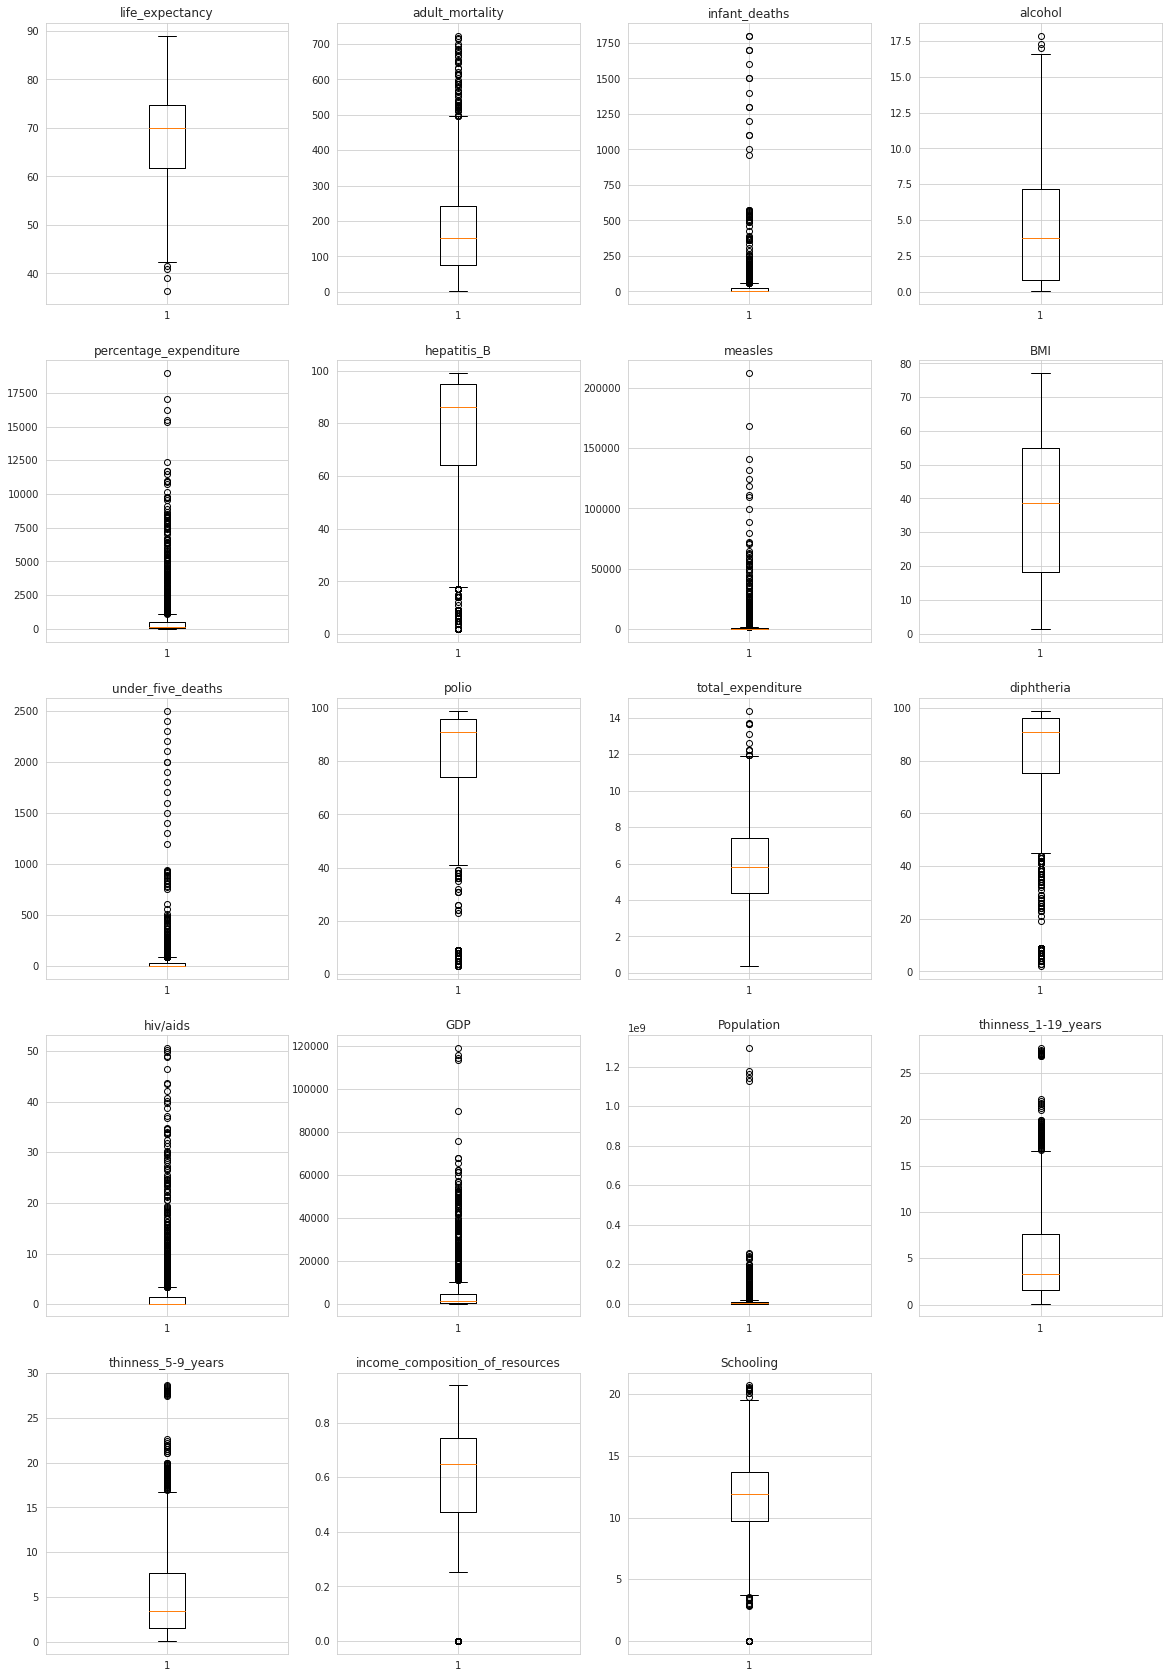

In [ ]:
column_dictionary = {'life_expectancy': 1 , 'adult_mortality': 2, 'infant_deaths': 3, 
               'alcohol': 4, 'percentage_expenditure': 5, 'hepatitis_B': 6,
               'measles': 7, 'BMI': 8, 'under_five_deaths': 9, 'polio': 10, 
               'total_expenditure': 11, 'diphtheria': 12, 'hiv/aids': 13, 'GDP': 14, 
               'Population': 15, 'thinness_1-19_years': 16, 'thinness_5-9_years': 17, 
               'income_composition_of_resources': 18, 'Schooling': 19}

plt.figure(figsize=(20,30))

for variable,i in column_dictionary.items():
  plt.subplot(5,4, i)
  plt.boxplot(life_df[variable])
  plt.title(variable)
plt.show()

Observations:
After a visual inspection, we note we have several variables with large amounts of outliers and 1 variable with no outliers. 

Let's statisticlly calculate how many outlieres there are for each variable using Tukey's method. This method considers all values that are outside the threshold of 1.5 times the IQR as outliers. 

In [ ]:
threshold = 1.5

for variable in column_dictionary:
  q75, q25 = np.percentile(life_df[variable], [75 ,25])
  iqr = q75 - q25
  min_val = q25 - (iqr*threshold)
  max_val = q75 + (iqr*threshold)
  print("The number of outliers in {} is {}".format(
        variable,len((np.where((life_df[variable] > max_val) 
        | (life_df[variable] < min_val))[0]))))

The number of outliers in life_expectancy is 4
The number of outliers in adult_mortality is 58
The number of outliers in infant_deaths is 198
The number of outliers in alcohol is 3
The number of outliers in percentage_expenditure is 232
The number of outliers in hepatitis_B is 216
The number of outliers in measles is 361
The number of outliers in BMI is 0
The number of outliers in under_five_deaths is 227
The number of outliers in polio is 159
The number of outliers in total_expenditure is 13
The number of outliers in diphtheria is 195
The number of outliers in hiv/aids is 309
The number of outliers in GDP is 244
The number of outliers in Population is 260
The number of outliers in thinness_1-19_years is 70
The number of outliers in thinness_5-9_years is 75
The number of outliers in income_composition_of_resources is 91
The number of outliers in Schooling is 32


From Tukey's method above, we realize we have too many outliers that will affect our analysis later on. We need to handle the outliers to allow us to have a more relable analysis. 

We will apply winsorization to deal with the outliers in the data.

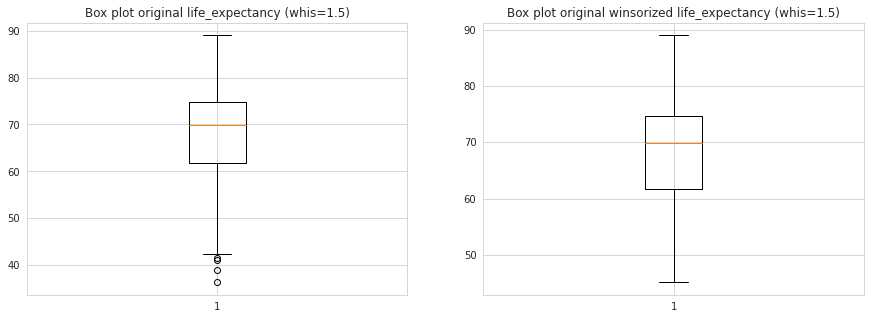

In [ ]:
from scipy.stats.mstats import winsorize

# Winsorized life_expectancy
plt.figure(figsize=(15,5))
winsorized_life_expectancy = winsorize(life_df['life_expectancy'], (0.01, 0))

plt.subplot(1,2,1)
plt.boxplot(life_df['life_expectancy'])
plt.title("Box plot original {} (whis=1.5)".format('life_expectancy'))

plt.subplot(1,2,2)
plt.boxplot(winsorized_life_expectancy)
plt.title("Box plot original {} (whis=1.5)".format('winsorized life_expectancy'))
plt.show()

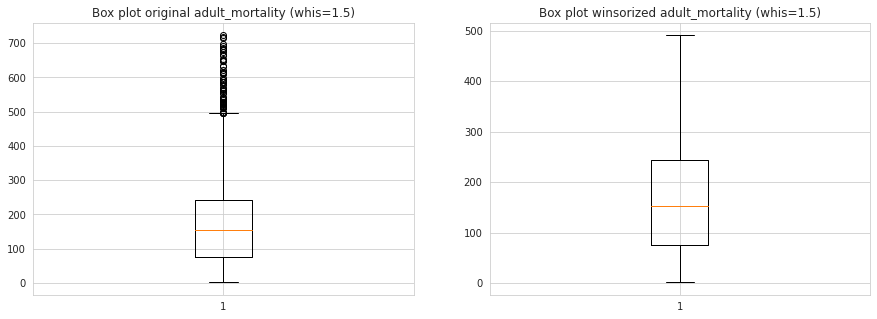

In [ ]:
# Winsorized adult_mortality
plt.figure(figsize=(15,5))

winsorized_adult_mortality = winsorize(life_df['adult_mortality'], (0, 0.03))

plt.subplot(1,2,1)
plt.boxplot(life_df['adult_mortality'])
plt.title("Box plot original {} (whis=1.5)".format('adult_mortality'))

plt.subplot(1,2,2)
plt.boxplot(winsorized_adult_mortality)
plt.title("Box plot {} (whis=1.5)".format('winsorized adult_mortality'))
plt.show()

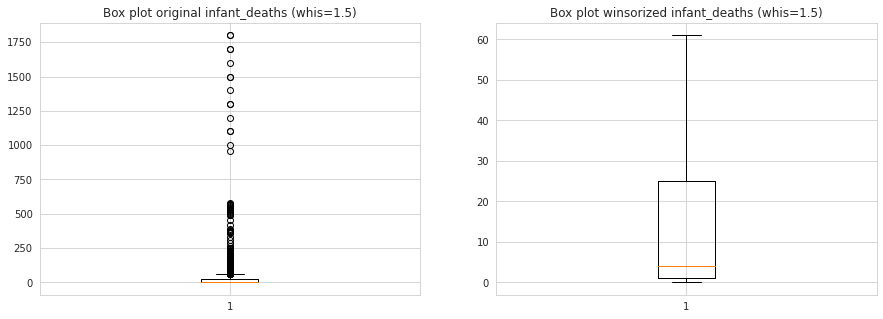

In [ ]:
# Winsorized infant_deaths
plt.figure(figsize=(15,5))

winsorized_infant_deaths = winsorize(life_df['infant_deaths'], (0, 0.10))

plt.subplot(1,2,1)
plt.boxplot(life_df['infant_deaths'])
plt.title("Box plot original {} (whis=1.5)".format('infant_deaths'))

plt.subplot(1,2,2)
plt.boxplot(winsorized_infant_deaths)
plt.title("Box plot {} (whis=1.5)".format('winsorized infant_deaths'))
plt.show()

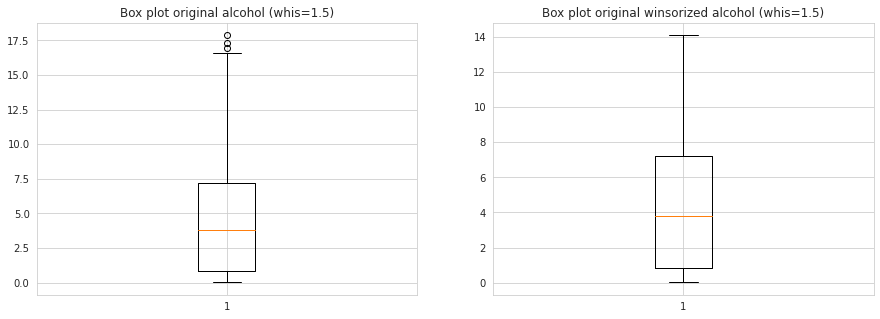

In [ ]:
# Winsorized alcohol
plt.figure(figsize=(15,5))
winsorized_alcohol = winsorize(life_df['alcohol'], (0, 0.01))

plt.subplot(1,2,1)
plt.boxplot(life_df['alcohol'])
plt.title("Box plot original {} (whis=1.5)".format('alcohol'))

plt.subplot(1,2,2)
plt.boxplot(winsorized_alcohol)
plt.title("Box plot original {} (whis=1.5)".format('winsorized alcohol'))
plt.show()

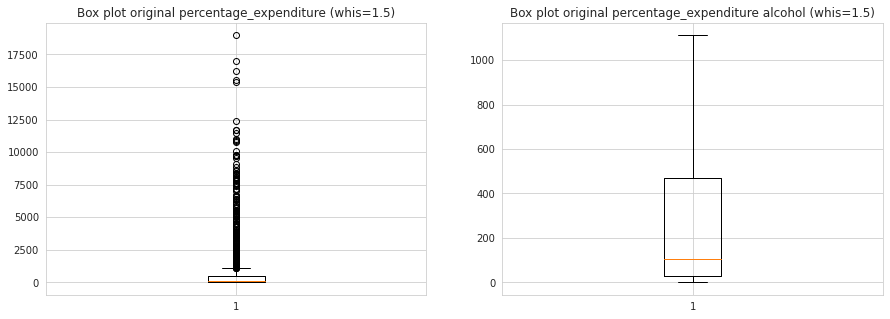

In [ ]:
# Winsorized percentage_expenditure
plt.figure(figsize=(15,5))
winsorized_percentage_expenditure = winsorize(
    life_df['percentage_expenditure'], (0, 0.12))

plt.subplot(1,2,1)
plt.boxplot(life_df['percentage_expenditure'])
plt.title("Box plot original {} (whis=1.5)".format('percentage_expenditure'))

plt.subplot(1,2,2)
plt.boxplot(winsorized_percentage_expenditure)
plt.title("Box plot original {} (whis=1.5)".format(
    'percentage_expenditure alcohol'))
plt.show()

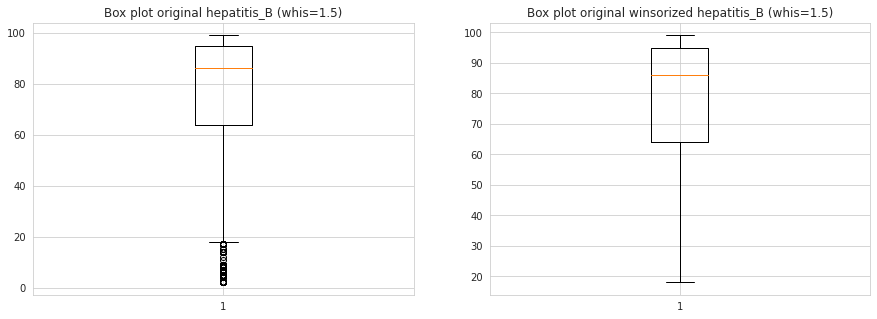

In [ ]:
# Winsorized hepatitis_B
plt.figure(figsize=(15,5))
winsorized_hepatitis_B = winsorize(life_df['hepatitis_B'], (0.11, 0))

plt.subplot(1,2,1)
plt.boxplot(life_df['hepatitis_B'])
plt.title("Box plot original {} (whis=1.5)".format('hepatitis_B'))

plt.subplot(1,2,2)
plt.boxplot(winsorized_hepatitis_B)
plt.title("Box plot original {} (whis=1.5)".format('winsorized hepatitis_B'))
plt.show()

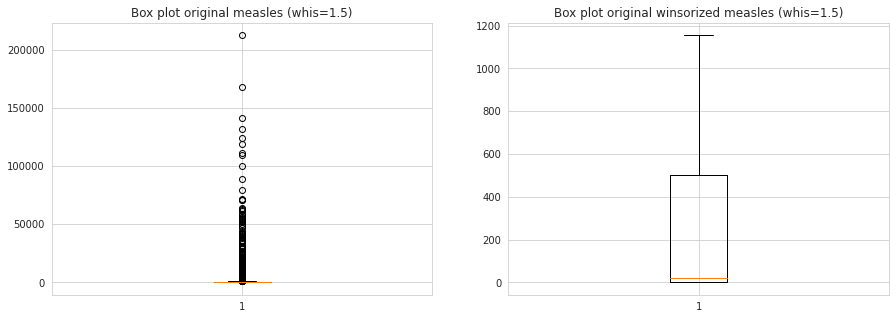

In [ ]:
# Winsorized measles
plt.figure(figsize=(15,5))
winsorized_measles = winsorize(life_df['measles'], (0, 0.19))

plt.subplot(1,2,1)
plt.boxplot(life_df['measles'])
plt.title("Box plot original {} (whis=1.5)".format('measles'))

plt.subplot(1,2,2)
plt.boxplot(winsorized_measles)
plt.title("Box plot original {} (whis=1.5)".format('winsorized measles'))
plt.show()

Measles required us to change close to 20% of the data to remove outliers. This could cause our results to change drastically. We'll drop measles.

In [ ]:
life_df = life_df.drop('measles', axis=1)

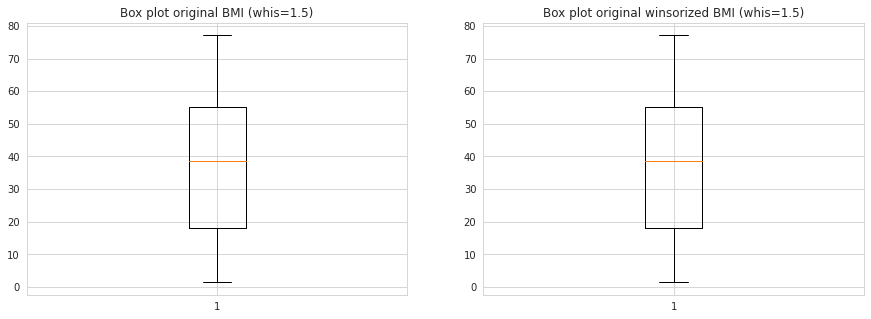

In [ ]:
# Winsorized BMI
plt.figure(figsize=(15,5))
winsorized_BMI = winsorize(life_df['BMI'], (0, 0))

plt.subplot(1,2,1)
plt.boxplot(life_df['BMI'])
plt.title("Box plot original {} (whis=1.5)".format('BMI'))

plt.subplot(1,2,2)
plt.boxplot(winsorized_BMI)
plt.title("Box plot original {} (whis=1.5)".format('winsorized BMI'))
plt.show()

BMI had no outliers. We can work with the original data as is. 

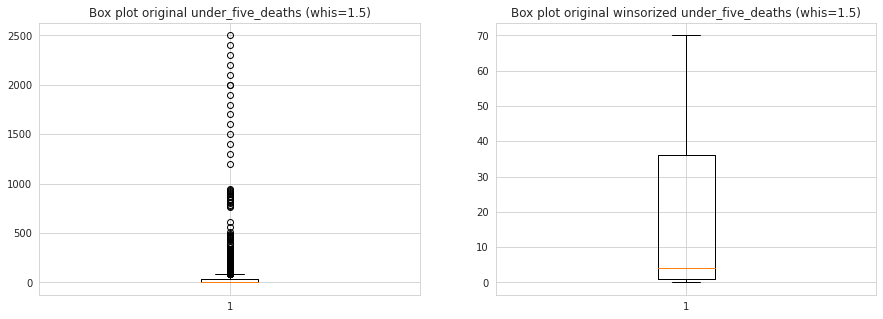

In [ ]:
# Winsorized under_five_deaths
plt.figure(figsize=(15,5))
winsorized_under_five_deaths = winsorize(life_df['under_five_deaths'], (0, 0.15))

plt.subplot(1,2,1)
plt.boxplot(life_df['under_five_deaths'])
plt.title("Box plot original {} (whis=1.5)".format('under_five_deaths'))

plt.subplot(1,2,2)
plt.boxplot(winsorized_under_five_deaths)
plt.title("Box plot original {} (whis=1.5)".format('winsorized under_five_deaths'))
plt.show()

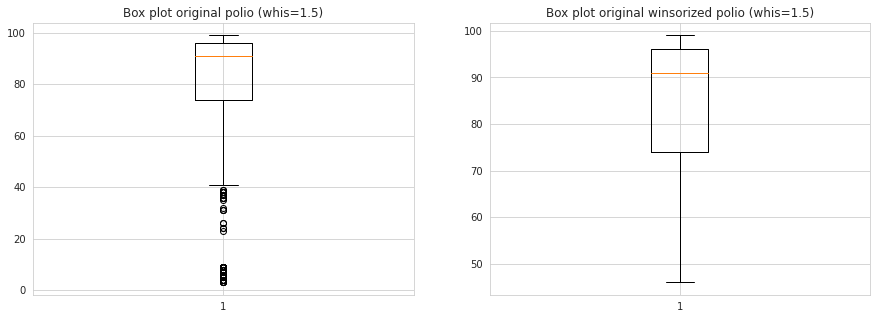

In [ ]:
# Winsorized polio
plt.figure(figsize=(15,5))
winsorized_polio = winsorize(life_df['polio'], (0.10, 0))

plt.subplot(1,2,1)
plt.boxplot(life_df['polio'])
plt.title("Box plot original {} (whis=1.5)".format('polio'))

plt.subplot(1,2,2)
plt.boxplot(winsorized_polio)
plt.title("Box plot original {} (whis=1.5)".format('winsorized polio'))
plt.show()

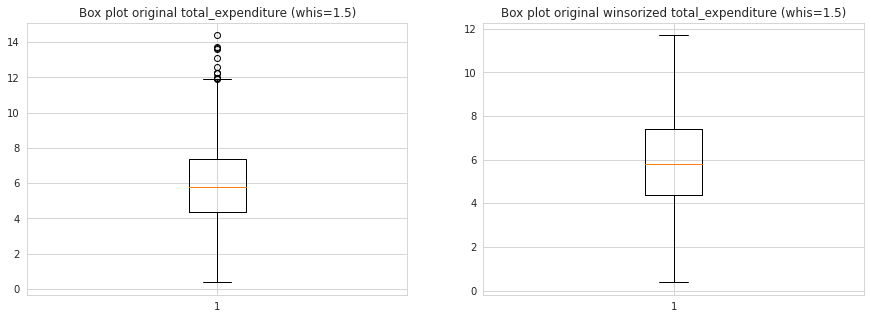

In [ ]:
# Winsorized total_expenditure
plt.figure(figsize=(15,5))
winsorized_total_expenditure = winsorize(life_df['total_expenditure'], (0, 0.01))

plt.subplot(1,2,1)
plt.boxplot(life_df['total_expenditure'])
plt.title("Box plot original {} (whis=1.5)".format('total_expenditure'))

plt.subplot(1,2,2)
plt.boxplot(winsorized_total_expenditure)
plt.title("Box plot original {} (whis=1.5)".format('winsorized total_expenditure'))
plt.show()

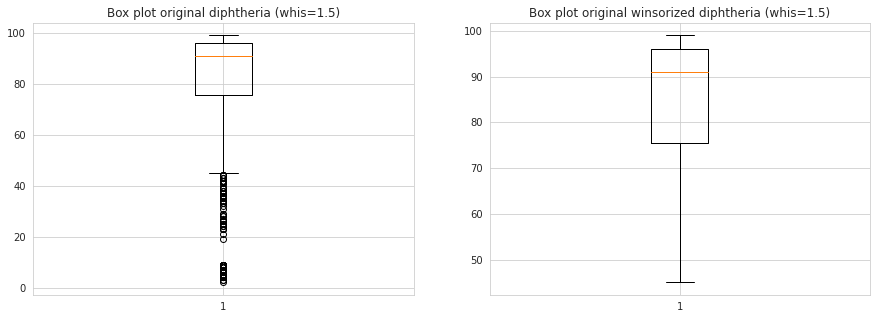

In [ ]:
# Winsorized diphtheria
plt.figure(figsize=(15,5))
winsorized_diphtheria = winsorize(life_df['diphtheria'], (0.10, 0))

plt.subplot(1,2,1)
plt.boxplot(life_df['diphtheria'])
plt.title("Box plot original {} (whis=1.5)".format('diphtheria'))

plt.subplot(1,2,2)
plt.boxplot(winsorized_diphtheria)
plt.title("Box plot original {} (whis=1.5)".format('winsorized diphtheria'))
plt.show()

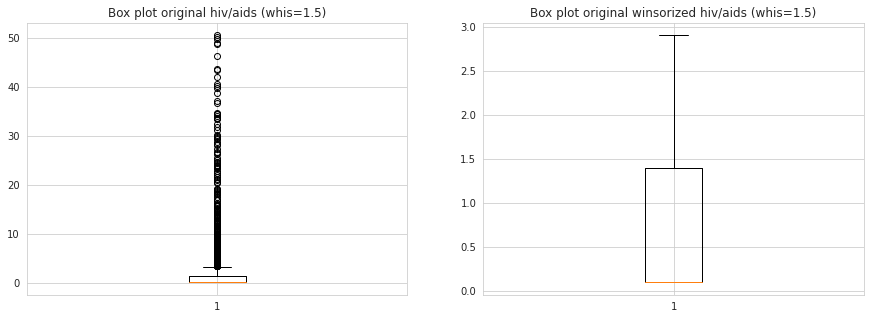

In [ ]:
# Winsorized hiv/aids
plt.figure(figsize=(15,5))
winsorized_hiv_aids = winsorize(life_df['hiv/aids'], (0, 0.17))

plt.subplot(1,2,1)
plt.boxplot(life_df['hiv/aids'])
plt.title("Box plot original {} (whis=1.5)".format('hiv/aids'))

plt.subplot(1,2,2)
plt.boxplot(winsorized_hiv_aids)
plt.title("Box plot original {} (whis=1.5)".format('winsorized hiv/aids'))
plt.show()

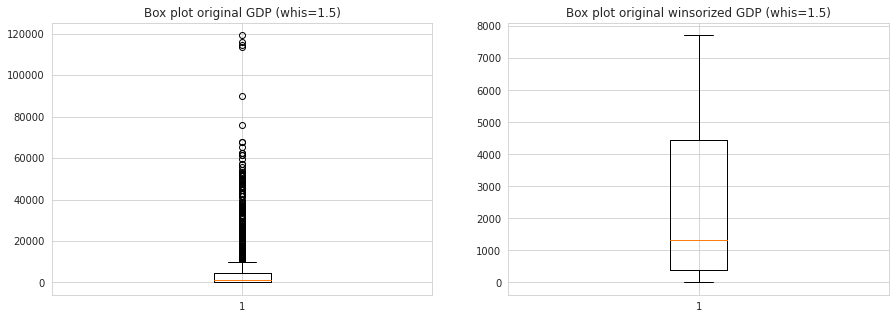

In [ ]:
# Winsorized GDP
plt.figure(figsize=(15,5))
winsorized_GDP = winsorize(life_df['GDP'], (0, 0.15))

plt.subplot(1,2,1)
plt.boxplot(life_df['GDP'])
plt.title("Box plot original {} (whis=1.5)".format('GDP'))

plt.subplot(1,2,2)
plt.boxplot(winsorized_GDP)
plt.title("Box plot original {} (whis=1.5)".format('winsorized GDP'))
plt.show()

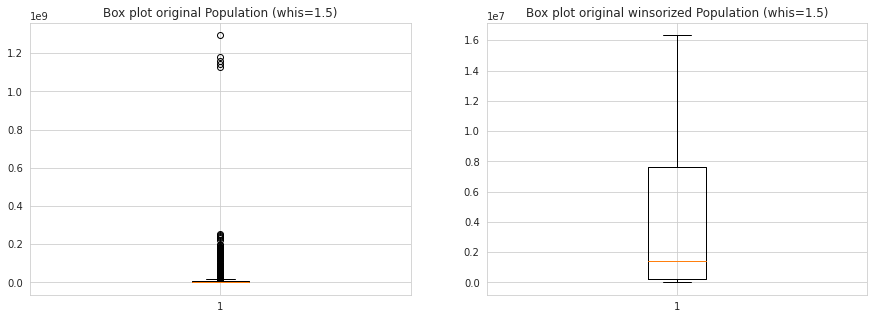

In [ ]:
# Winsorized Population
plt.figure(figsize=(15,5))
winsorized_population = winsorize(life_df['Population'], (0, 0.15))

plt.subplot(1,2,1)
plt.boxplot(life_df['Population'])
plt.title("Box plot original {} (whis=1.5)".format('Population'))

plt.subplot(1,2,2)
plt.boxplot(winsorized_population)
plt.title("Box plot original {} (whis=1.5)".format('winsorized Population'))
plt.show()

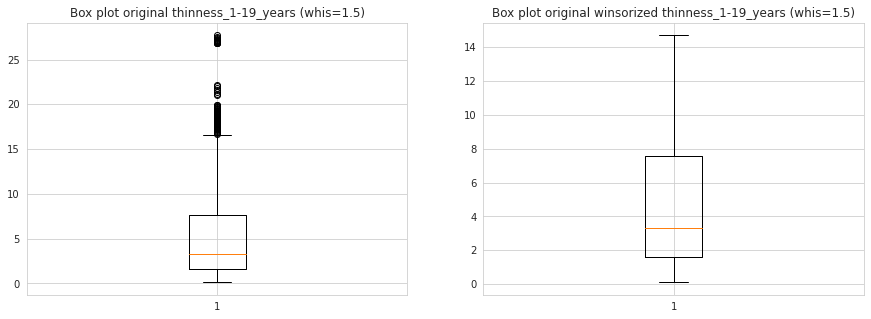

In [ ]:
# Winsorized thinness_1-19_years
plt.figure(figsize=(15,5))
winsorized_thinness_1_19_years = winsorize(life_df['thinness_1-19_years'], (0, 0.05))

plt.subplot(1,2,1)
plt.boxplot(life_df['thinness_1-19_years'])
plt.title("Box plot original {} (whis=1.5)".format('thinness_1-19_years'))

plt.subplot(1,2,2)
plt.boxplot(winsorized_thinness_1_19_years)
plt.title("Box plot original {} (whis=1.5)".format('winsorized thinness_1-19_years'))
plt.show()

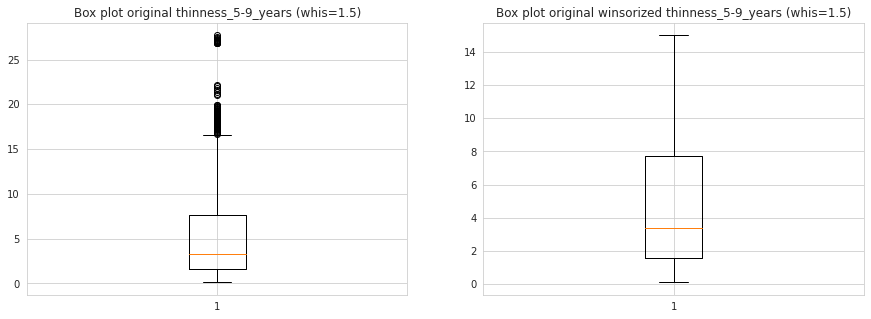

In [ ]:
# Winsorized thinness_5-9_years
plt.figure(figsize=(15,5))
winsorized_thinness_5_9_years = winsorize(life_df['thinness_5-9_years'], (0, 0.05))

plt.subplot(1,2,1)
plt.boxplot(life_df['thinness_1-19_years'])
plt.title("Box plot original {} (whis=1.5)".format('thinness_5-9_years'))

plt.subplot(1,2,2)
plt.boxplot(winsorized_thinness_5_9_years)
plt.title("Box plot original {} (whis=1.5)".format('winsorized thinness_5-9_years'))
plt.show()

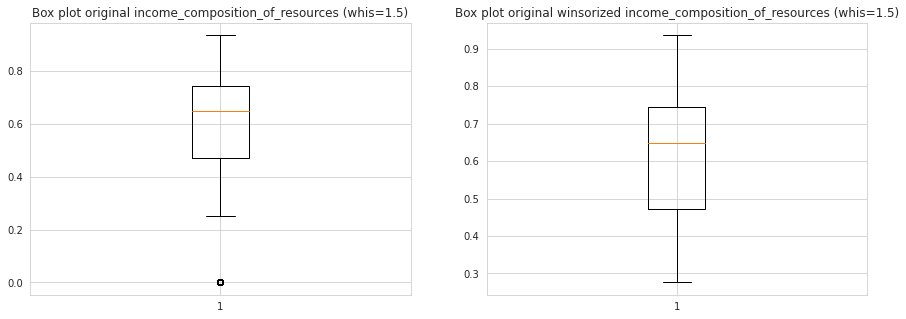

In [ ]:
# Winsorized income_composition_of_resources
plt.figure(figsize=(15,5))
winsorized_income_composition = winsorize(
    life_df['income_composition_of_resources'], (0.05, 0))

plt.subplot(1,2,1)
plt.boxplot(life_df['income_composition_of_resources'])
plt.title("Box plot original {} (whis=1.5)".format('income_composition_of_resources'))

plt.subplot(1,2,2)
plt.boxplot(winsorized_income_composition)
plt.title("Box plot original {} (whis=1.5)".format('winsorized income_composition_of_resources'))
plt.show()

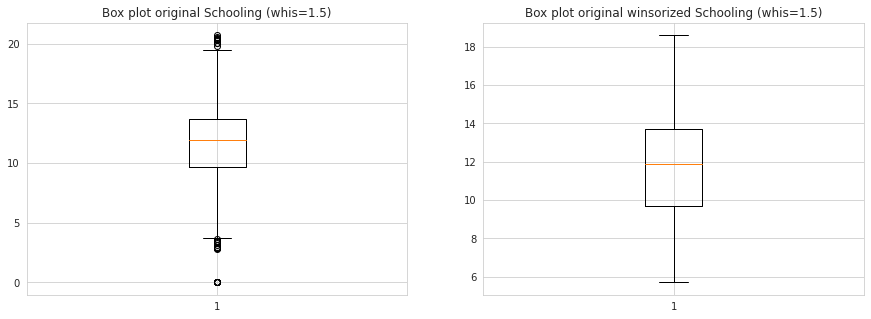

In [ ]:
# Winsorized Schooling
plt.figure(figsize=(15,5))
winsorized_schooling = winsorize(life_df['Schooling'], (0.05, 0.01))

plt.subplot(1,2,1)
plt.boxplot(life_df['Schooling'])
plt.title("Box plot original {} (whis=1.5)".format('Schooling'))

plt.subplot(1,2,2)
plt.boxplot(winsorized_schooling)
plt.title("Box plot original {} (whis=1.5)".format('winsorized Schooling'))
plt.show()

We have completed the data cleaning process. I will now add the new winsorized variables to the dataframe. 

In [ ]:
life_df['winsorized_life_expectancy'] = winsorized_life_expectancy
life_df['winsorized_adult_mortality'] = winsorized_adult_mortality
life_df['winsorized_infant_deaths'] = winsorized_infant_deaths
life_df['winsorized_alcohol'] = winsorized_alcohol
life_df['winsorized_percentage_expenditure'] = winsorized_percentage_expenditure
life_df['winsorized_hepatitis_B'] = winsorized_hepatitis_B
life_df['winsorized_BMI'] = winsorized_BMI
life_df['winsorized_under_five_deaths'] = winsorized_under_five_deaths
life_df['winsorized_polio'] = winsorized_polio
life_df['winsorized_total_expenditure'] = winsorized_total_expenditure
life_df['winsorized_diphtheria'] = winsorized_diphtheria
life_df['winsorized_hiv_aids'] = winsorized_hiv_aids
life_df['winsorized_GDP'] = winsorized_GDP
life_df['winsorized_population'] = winsorized_population
life_df['winsorized_thinness_1_19_years'] = winsorized_thinness_1_19_years
life_df['winsorized_thinness_5_9_years'] = winsorized_thinness_5_9_years
life_df['winsorized_income_composition'] = winsorized_income_composition
life_df['winsorized_schooling'] = winsorized_schooling

Let's apply Tukey's method after winsorization to double check for outliers.

In [ ]:
winz_life = life_df.iloc[:,21:]

for variable in list(winz_life.columns):
  q75, q25 = np.percentile(winz_life[variable], [75 ,25])
  iqr = q75 - q25
  min_val = q25 - (iqr*threshold)
  max_val = q75 + (iqr*threshold)
  print("The number of outliers in {} is {}".format(
        variable,len((np.where((winz_life[variable] > max_val) 
        | (winz_life[variable] < min_val))[0]))))

The number of outliers in winsorized_life_expectancy is 0
The number of outliers in winsorized_adult_mortality is 0
The number of outliers in winsorized_infant_deaths is 0
The number of outliers in winsorized_alcohol is 0
The number of outliers in winsorized_percentage_expenditure is 0
The number of outliers in winsorized_hepatitis_B is 0
The number of outliers in winsorized_BMI is 0
The number of outliers in winsorized_under_five_deaths is 0
The number of outliers in winsorized_polio is 0
The number of outliers in winsorized_total_expenditure is 0
The number of outliers in winsorized_diphtheria is 0
The number of outliers in winsorized_hiv_aids is 0
The number of outliers in winsorized_GDP is 0
The number of outliers in winsorized_population is 0
The number of outliers in winsorized_thinness_1_19_years is 0
The number of outliers in winsorized_thinness_5_9_years is 0
The number of outliers in winsorized_income_composition is 0
The number of outliers in winsorized_schooling is 0


# **Univariate Analysis**

In [ ]:
# Descriptive univariate statistics of our data
life_df.describe()

NameError: ignored

In [ ]:
# Descriptive statistics for our categorical variables. 
life_df.describe(include=['O'])

NameError: ignored

In [ ]:
plt.figure(figsize=(18,15))

# histograms of the winsorized data
plt.subplot(5, 4, 1)
plt.hist(life_df['winsorized_life_expectancy'])
plt.title("histogram of winsorized_life_expectancy")

plt.subplot(5, 4, 2)
plt.hist(life_df['winsorized_adult_mortality'])
plt.title("histogram of winsorized_adult_mortality")

plt.subplot(5, 4, 3)
plt.hist(life_df['winsorized_infant_deaths'])
plt.title("histogram of winsorized_infant_deaths")

plt.subplot(5,4, 4)
plt.hist(life_df['winsorized_alcohol'])
plt.title("histogram of winsorized_alcohol")

plt.subplot(5,4, 5)
plt.hist(life_df['winsorized_percentage_expenditure'])
plt.title("histogram of winsorized_percentage_expenditure")

plt.subplot(5,4, 6)
plt.hist(life_df['winsorized_hepatitis_B'])
plt.title("histogram of winsorized_hepatitis_B")

plt.subplot(5,4, 7)
plt.hist(life_df['winsorized_BMI'])
plt.title("histogram of winsorized_BMI")

plt.subplot(5,4, 8)
plt.hist(life_df['winsorized_under_five_deaths'])
plt.title("histogram of winsorized_under_five_deaths")

plt.subplot(5,4, 9)
plt.hist(life_df['winsorized_polio'])
plt.title("histogram of winsorized_polio")

plt.subplot(5,4, 10)
plt.hist(life_df['winsorized_total_expenditure'])
plt.title("histogram of winsorized_total_expenditure")

plt.subplot(5,4, 11)
plt.hist(life_df['winsorized_diphtheria'])
plt.title("histogram of winsorized_diphtheria")

plt.subplot(5,4, 12)
plt.hist(life_df['winsorized_hiv_aids'])
plt.title("histogram of winsorized_hiv_aids")

plt.subplot(5,4, 13)
plt.hist(life_df['winsorized_GDP'])
plt.title("histogram of winsorized_GDP")

plt.subplot(5,4, 14)
plt.hist(life_df['winsorized_population'])
plt.title("histogram of winsorized_population")

plt.subplot(5,4, 15)
plt.hist(life_df['winsorized_thinness_1_19_years'])
plt.title("histogram of winsorized_thinness_1_19_years")

plt.subplot(5,4, 16)
plt.hist(life_df['winsorized_thinness_5_9_years'])
plt.title("histogram of winsorized_thinness_5_9_years")

plt.subplot(5,4, 17)
plt.hist(life_df['winsorized_income_composition'])
plt.title("histogram of winsorized_income_composition")

plt.subplot(5,4, 18)
plt.hist(life_df['winsorized_schooling'])
plt.title("histogram of winsorized_schooling")
plt.tight_layout()
plt.show()

With above's histogram plots, we can get a sense of the distributions of our new variables. Life expectancy, total expenditure, and schooling are the ones appear to be normally distributed. Besides these three, we mostly have highly skewed variables. 

# **Multivariate Analysis**

We will drop the variables that are not winsorized from our dataframe.

In [ ]:
life_df.drop(columns=['life_expectancy', 'adult_mortality',
       'infant_deaths', 'alcohol', 'percentage_expenditure', 'hepatitis_B',
       'BMI', 'under_five_deaths', 'polio', 'total_expenditure', 'diphtheria',
       'hiv/aids', 'GDP', 'Population', 'thinness_1-19_years',
       'thinness_5-9_years', 'income_composition_of_resources', 'Schooling'], inplace=True)

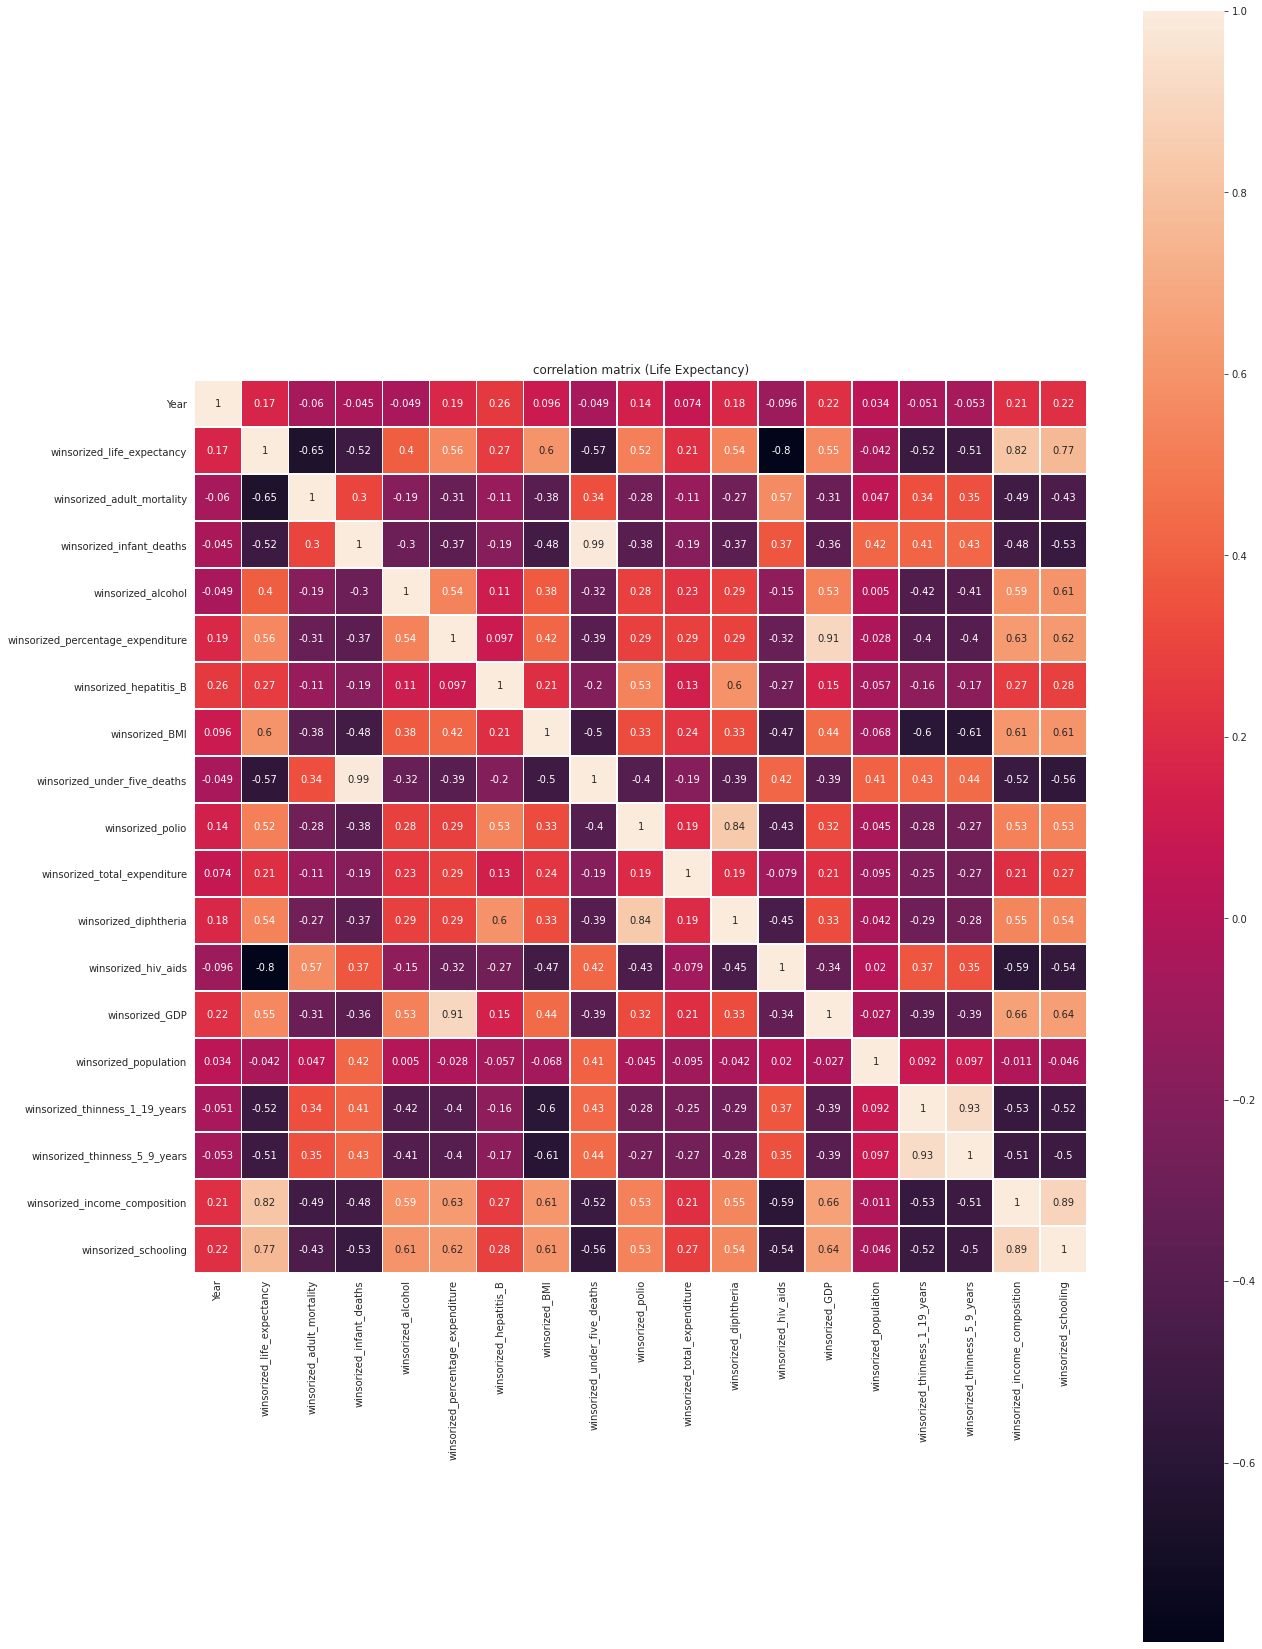

In [ ]:
# Below is a correlation heatmap. Those with lighter colors indicate a 
# higher correlation. Those with darker colors indicate a low correlation.

plt.figure(figsize=(20,30))
corrmat_life = life_df.corr()
sns.heatmap(corrmat_life, square=True, annot=True, linewidths=.5)
plt.title("correlation matrix (Life Expectancy)")
plt.show()

**Observations:** 

*   Winsorized schooling and winsorized income composition are highly correlated. 
*   Winsorized polio is highly correlated to winsorized diptheria. 
*   Adult mortality has a negative relationship to life expectancy which is to be expected. As adult mortality increases, life experctancy decreases. 

In [ ]:
life_df.columns

Index(['Country', 'Year', 'Status', 'winsorized_life_expectancy',
       'winsorized_adult_mortality', 'winsorized_infant_deaths',
       'winsorized_alcohol', 'winsorized_percentage_expenditure',
       'winsorized_hepatitis_B', 'winsorized_BMI',
       'winsorized_under_five_deaths', 'winsorized_polio',
       'winsorized_total_expenditure', 'winsorized_diphtheria',
       'winsorized_hiv_aids', 'winsorized_GDP', 'winsorized_population',
       'winsorized_thinness_1_19_years', 'winsorized_thinness_5_9_years',
       'winsorized_income_composition', 'winsorized_schooling'],
      dtype='object')

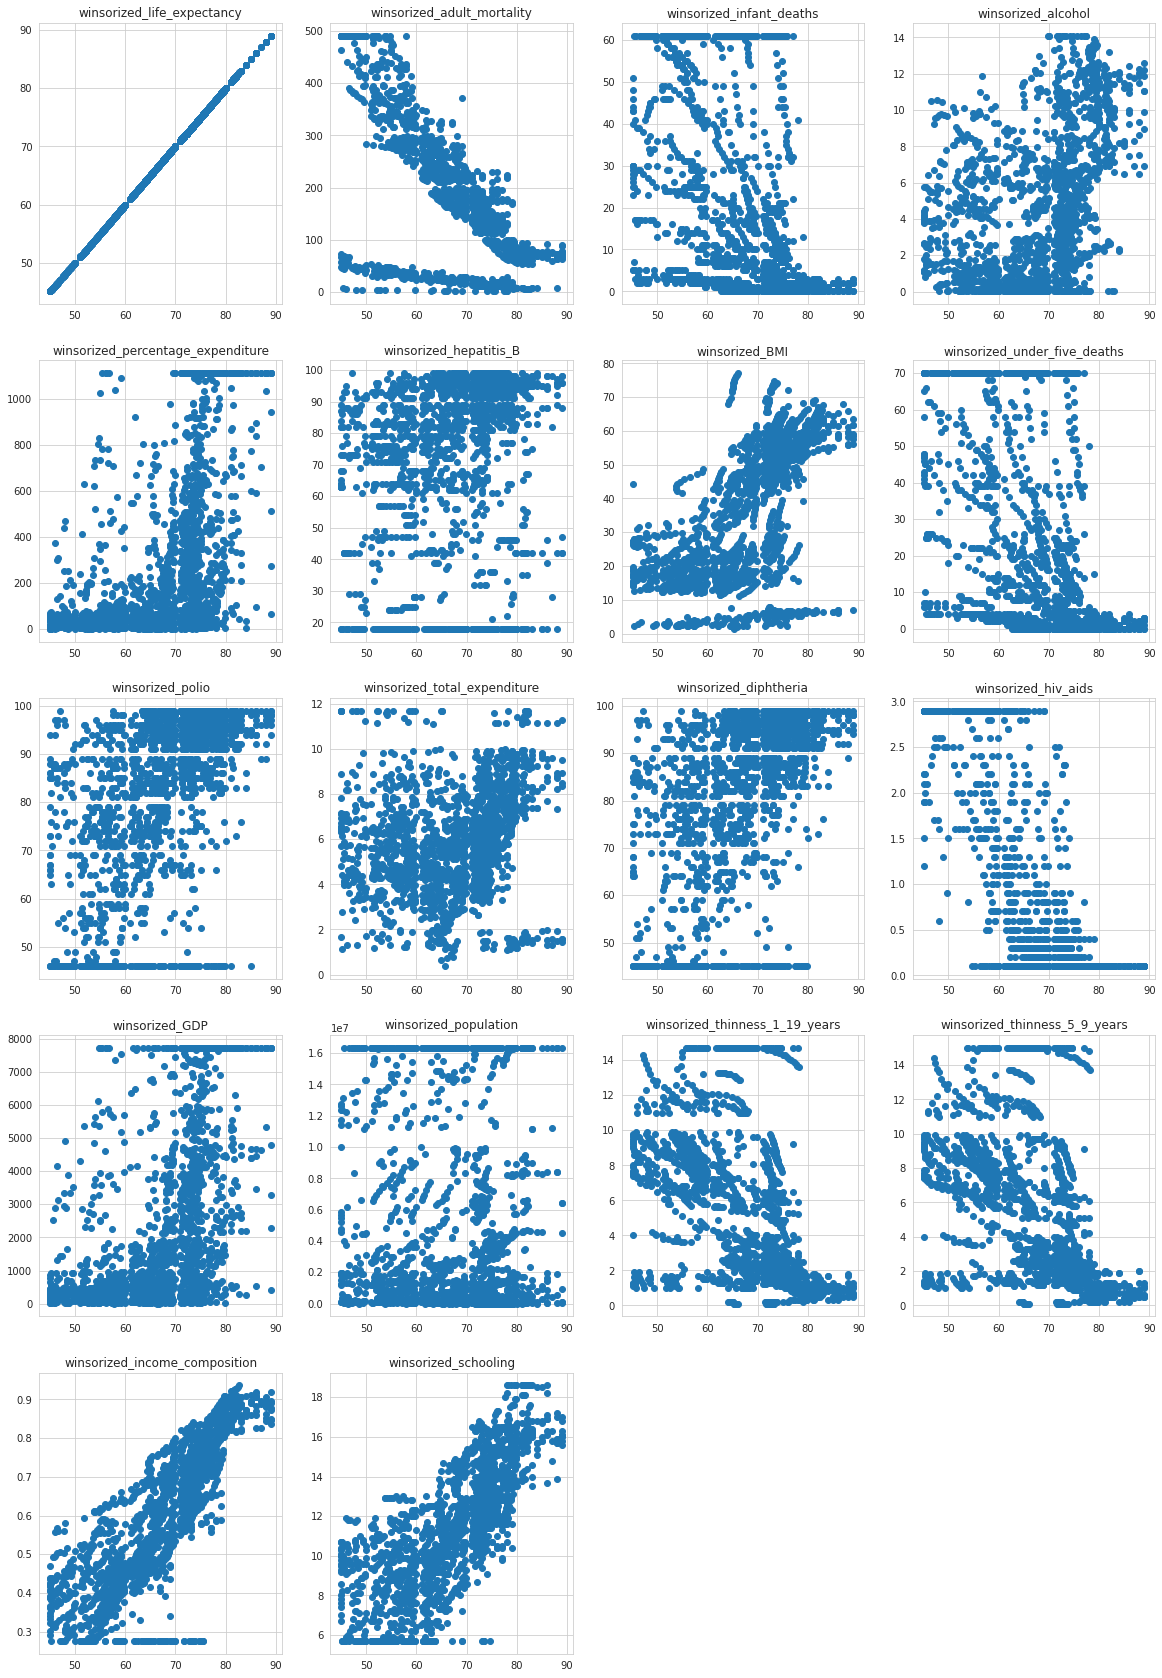

In [ ]:
winsorized_dict = {'winsorized_life_expectancy': 1 , 
                   'winsorized_adult_mortality': 2, 'winsorized_infant_deaths': 3, 
               'winsorized_alcohol': 4, 'winsorized_percentage_expenditure': 5, 
               'winsorized_hepatitis_B': 6, 'winsorized_BMI': 7, 
               'winsorized_under_five_deaths': 8, 'winsorized_polio': 9, 
               'winsorized_total_expenditure': 10, 'winsorized_diphtheria': 11, 
               'winsorized_hiv_aids': 12, 'winsorized_GDP': 13, 
               'winsorized_population': 14, 'winsorized_thinness_1_19_years': 15, 
               'winsorized_thinness_5_9_years': 16, 
               'winsorized_income_composition': 17, 
               'winsorized_schooling': 18}

plt.figure(figsize=(20,30))

for variable,i in winsorized_dict.items():
                     plt.subplot(5,4,i)
                     plt.scatter(life_df["winsorized_life_expectancy"], life_df[variable])
                     plt.title(variable)
plt.show()

**Observations:**

Both schooling and income composition have a strong positive effect in life expectancy. Adult mortality has a negative relationship to life expectancy which is to be expected. As adult mortality increases, life experctancy decreases.

# **Feature Engineering**

In [ ]:
# Correlation matrix
life_df.corr()

,Year,winsorized_life_expectancy,winsorized_adult_mortality,winsorized_infant_deaths,winsorized_alcohol,winsorized_percentage_expenditure,winsorized_hepatitis_B,winsorized_BMI,winsorized_under_five_deaths,winsorized_polio,winsorized_total_expenditure,winsorized_diphtheria,winsorized_hiv_aids,winsorized_GDP,winsorized_population,winsorized_thinness_1_19_years,winsorized_thinness_5_9_years,winsorized_income_composition,winsorized_schooling
Year,1.000000,0.170919,-0.059806,-0.045499,-0.048590,0.185544,0.256542,0.096059,-0.048774,0.143089,0.073834,0.181178,-0.096402,0.217207,0.033508,-0.051265,-0.053327,0.214713,0.215606
winsorized_life_expectancy,0.170919,1.000000,-0.654255,-0.516494,0.396073,0.557117,0.268086,0.601434,-0.568744,0.521506,0.208400,0.535687,-0.797337,0.554577,-0.042054,-0.519268,-0.511774,0.823222,0.767677
winsorized_adult_mortality,-0.059806,-0.654255,1.000000,0.303275,-0.191173,-0.313519,-0.113036,-0.384986,0.339109,-0.279514,-0.114441,-0.274879,0.571698,-0.307043,0.047397,0.338384,0.345448,-0.488595,-0.432362
winsorized_infant_deaths,-0.045499,-0.516494,0.303275,1.000000,-0.301196,-0.367645,-0.192581,-0.475304,0.988271,-0.377196,-0.192206,-0.369402,0.365275,-0.362562,0.422674,0.411349,0.430696,-0.478552,-0.525904
winsorized_alcohol,-0.048590,0.396073,-0.191173,-0.301196,1.000000,0.535143,0.113096,0.380291,-0.318534,0.284174,0.232997,0.289133,-0.146919,0.527650,0.005039,-0.418899,-0.408302,0.590256,0.606401
winsorized_percentage_expenditure,0.185544,0.557117,-0.313519,-0.367645,0.535143,1.000000,0.097402,0.420946,-0.385190,0.290508,0.287113,0.294386,-0.317204,0.907864,-0.028213,-0.396491,-0.396421,0.630088,0.621702
winsorized_hepatitis_B,0.256542,0.268086,-0.113036,-0.192581,0.113096,0.097402,1.000000,0.208182,-0.202538,0.530845,0.132563,0.596233,-0.273730,0.145495,-0.057249,-0.156460,-0.166761,0.269518,0.283186
winsorized_BMI,0.096059,0.601434,-0.384986,-0.475304,0.380291,0.420946,0.208182,1.000000,-0.500092,0.329588,0.236184,0.328345,-0.474730,0.444428,-0.068135,-0.596775,-0.605480,0.611216,0.605653
winsorized_under_five_deaths,-0.048774,-0.568744,0.339109,0.988271,-0.318534,-0.385190,-0.202538,-0.500092,1.000000,-0.399871,-0.188255,-0.390884,0.418504,-0.386761,0.406839,0.428479,0.444907,-0.522800,-0.563647
winsorized_polio,0.143089,0.521506,-0.279514,-0.377196,0.284174,0.290508,0.530845,0.329588,-0.399871,1.000000,0.185629,0.839892,-0.434397,0.323784,-0.045441,-0.276907,-0.272601,0.526936,0.533630


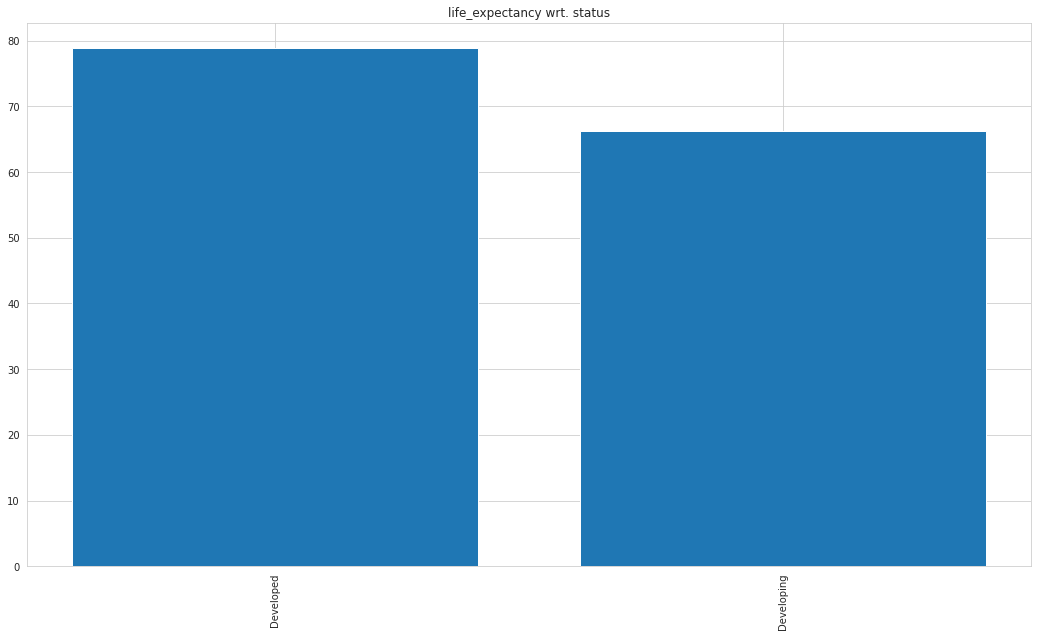

In [ ]:
plt.figure(figsize=(18, 10))
plt.bar(life_df.groupby("Status")
        ["winsorized_life_expectancy"].mean().index, 
        life_df.groupby("Status")["winsorized_life_expectancy"].mean())

plt.title("life_expectancy wrt. status")
plt.xticks(rotation="vertical")
plt.show()

The highest life expectancy with respect to country can be found in Zimbabwe, Zambia, and Vanuatu.

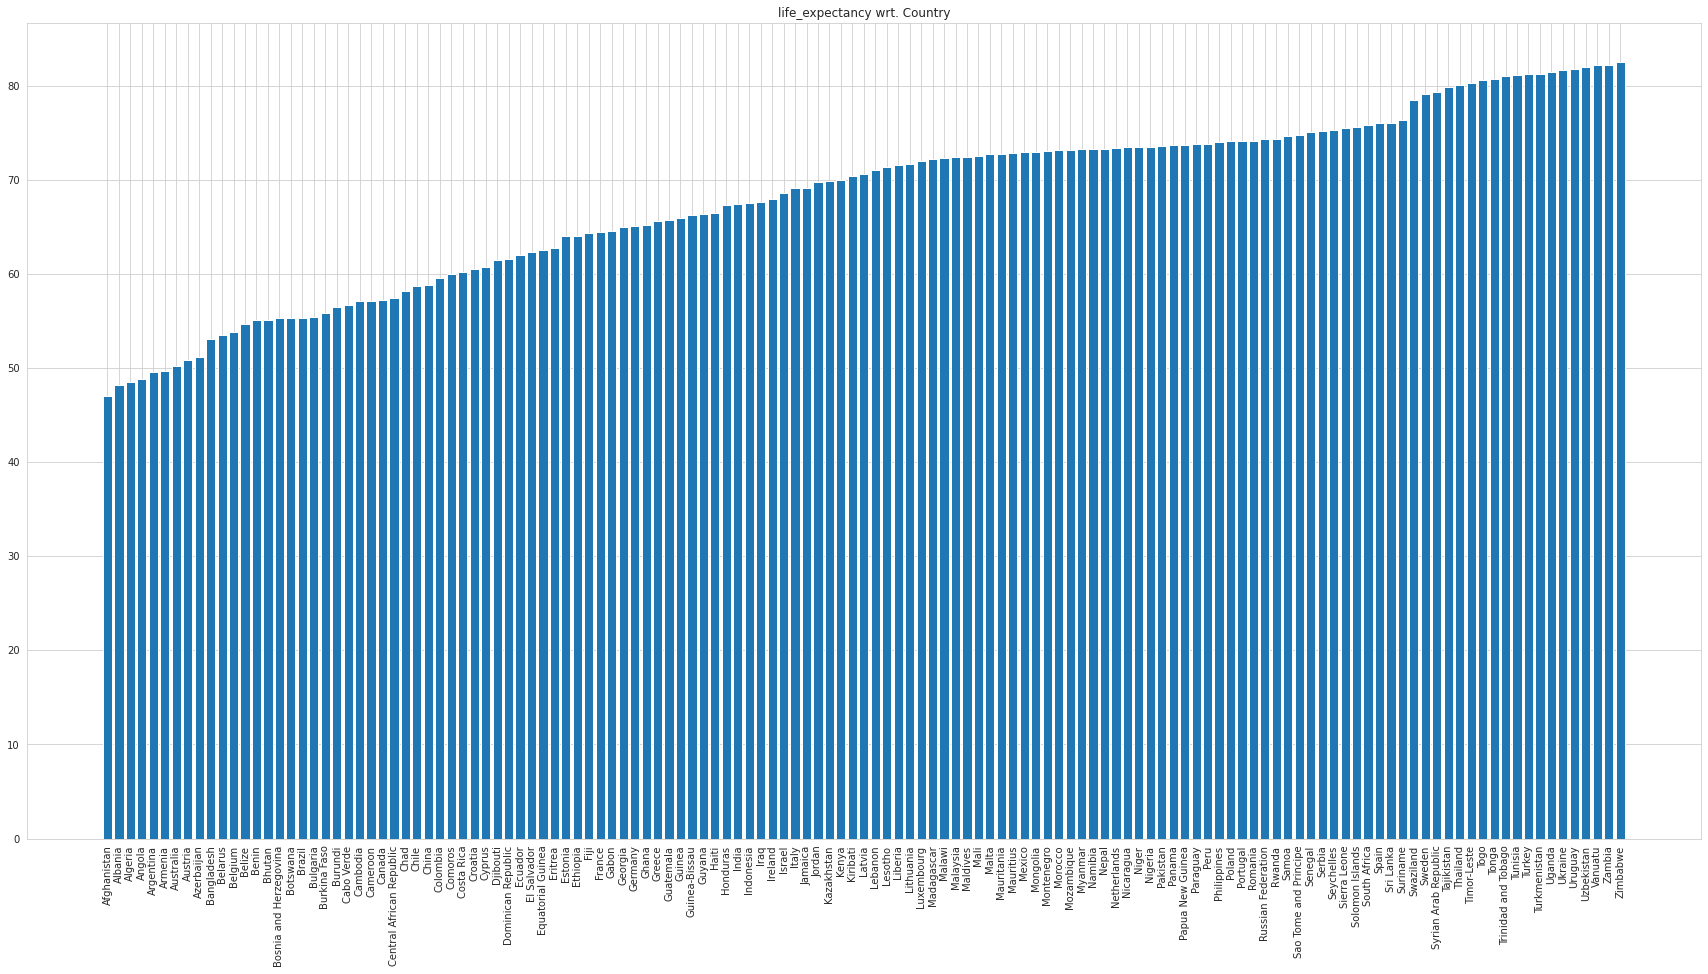

In [ ]:
plt.figure(figsize=(30, 15))
plt.bar(life_df.groupby("Country")
        ["winsorized_life_expectancy"].mean().index, 
        life_df.groupby("Country")["winsorized_life_expectancy"].mean().sort_values(ascending=True))

plt.title("life_expectancy wrt. Country")
plt.xticks(rotation="vertical")
plt.show()

Average life expectancy has gradually increased throughout theyears. 

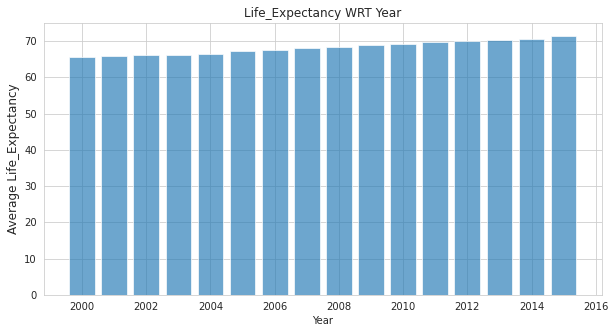

In [ ]:
plt.figure(figsize=(10,5))
plt.bar(life_df.groupby('Year')['Year'].count().index,life_df.groupby('Year')['winsorized_life_expectancy'].mean(),alpha=0.65)
plt.xlabel("Year")
plt.ylabel("Average Life_Expectancy",fontsize=12)
plt.title("Life_Expectancy WRT Year")
plt.show()

It could be useful to run PCA on our data to reduce the amount of dimensions since there are close to 20 variables. 

In [ ]:
life_df.corr()

,Year,winsorized_life_expectancy,winsorized_adult_mortality,winsorized_infant_deaths,winsorized_alcohol,winsorized_percentage_expenditure,winsorized_hepatitis_B,winsorized_BMI,winsorized_under_five_deaths,winsorized_polio,winsorized_total_expenditure,winsorized_diphtheria,winsorized_hiv_aids,winsorized_GDP,winsorized_population,winsorized_thinness_1_19_years,winsorized_thinness_5_9_years,winsorized_income_composition,winsorized_schooling
Year,1.000000,0.170919,-0.059806,-0.045499,-0.048590,0.185544,0.256542,0.096059,-0.048774,0.143089,0.073834,0.181178,-0.096402,0.217207,0.033508,-0.051265,-0.053327,0.214713,0.215606
winsorized_life_expectancy,0.170919,1.000000,-0.654255,-0.516494,0.396073,0.557117,0.268086,0.601434,-0.568744,0.521506,0.208400,0.535687,-0.797337,0.554577,-0.042054,-0.519268,-0.511774,0.823222,0.767677
winsorized_adult_mortality,-0.059806,-0.654255,1.000000,0.303275,-0.191173,-0.313519,-0.113036,-0.384986,0.339109,-0.279514,-0.114441,-0.274879,0.571698,-0.307043,0.047397,0.338384,0.345448,-0.488595,-0.432362
winsorized_infant_deaths,-0.045499,-0.516494,0.303275,1.000000,-0.301196,-0.367645,-0.192581,-0.475304,0.988271,-0.377196,-0.192206,-0.369402,0.365275,-0.362562,0.422674,0.411349,0.430696,-0.478552,-0.525904
winsorized_alcohol,-0.048590,0.396073,-0.191173,-0.301196,1.000000,0.535143,0.113096,0.380291,-0.318534,0.284174,0.232997,0.289133,-0.146919,0.527650,0.005039,-0.418899,-0.408302,0.590256,0.606401
winsorized_percentage_expenditure,0.185544,0.557117,-0.313519,-0.367645,0.535143,1.000000,0.097402,0.420946,-0.385190,0.290508,0.287113,0.294386,-0.317204,0.907864,-0.028213,-0.396491,-0.396421,0.630088,0.621702
winsorized_hepatitis_B,0.256542,0.268086,-0.113036,-0.192581,0.113096,0.097402,1.000000,0.208182,-0.202538,0.530845,0.132563,0.596233,-0.273730,0.145495,-0.057249,-0.156460,-0.166761,0.269518,0.283186
winsorized_BMI,0.096059,0.601434,-0.384986,-0.475304,0.380291,0.420946,0.208182,1.000000,-0.500092,0.329588,0.236184,0.328345,-0.474730,0.444428,-0.068135,-0.596775,-0.605480,0.611216,0.605653
winsorized_under_five_deaths,-0.048774,-0.568744,0.339109,0.988271,-0.318534,-0.385190,-0.202538,-0.500092,1.000000,-0.399871,-0.188255,-0.390884,0.418504,-0.386761,0.406839,0.428479,0.444907,-0.522800,-0.563647
winsorized_polio,0.143089,0.521506,-0.279514,-0.377196,0.284174,0.290508,0.530845,0.329588,-0.399871,1.000000,0.185629,0.839892,-0.434397,0.323784,-0.045441,-0.276907,-0.272601,0.526936,0.533630


We will pick variables that are not unrelated(0.0) but also not too correlated(.8+) as these are conditions to be able to perform PCA. To perform PCA, we will drop country and year because they aren't significant to our analysis. 

Because we want to include status of a country's development in our analysis and it is a text-variable, we will one-hot encode it to be able to include it in our model. 

In [ ]:
# One-hot encoding: 
life_df= pd.concat([life_df, pd.get_dummies(life_df["Status"])], axis=1)
life_df.drop(columns=['Country', 'Year', 'Status'],inplace=True)

From above heatmap we noted variables winsorized percentage expenditure, winsorized schooling, and winsorized GDP were highly correlated to each other. We will use these to create a new variable to replace them. 

In [ ]:
# We will create a new variable from a select few highly correlated variables
# using PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X = life_df[['winsorized_percentage_expenditure', 'winsorized_schooling', 'winsorized_GDP']]
X = StandardScaler().fit_transform(X)

sklearn_pca = PCA(n_components=1)
life_df["pca_1"] = sklearn_pca.fit_transform(X)

print(
    'The percentage of total variance in the dataset explained by each',
    'component from Sklearn PCA.\n',
    sklearn_pca.explained_variance_ratio_
)

The percentage of total variance in the dataset explained by each component from Sklearn PCA.
 [0.81904498]


In [ ]:
x_corr_check = life_df[['winsorized_life_expectancy', 'pca_1',
                        'winsorized_percentage_expenditure', 'winsorized_schooling', 
                        'winsorized_GDP']]

x_corr_check.corr()

,winsorized_life_expectancy,pca_1,winsorized_percentage_expenditure,winsorized_schooling,winsorized_GDP
winsorized_life_expectancy,1.000000,0.683597,0.557117,0.767677,0.554577
pca_1,0.683597,1.000000,0.940797,0.820175,0.948340
winsorized_percentage_expenditure,0.557117,0.940797,1.000000,0.621702,0.907864
winsorized_schooling,0.767677,0.820175,0.621702,1.000000,0.643452
winsorized_GDP,0.554577,0.948340,0.907864,0.643452,1.000000


In [ ]:
# We will create a second variable from a select few highly correlated variables

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X = life_df[['winsorized_polio', 'winsorized_hepatitis_B', 'winsorized_diphtheria']]
X = StandardScaler().fit_transform(X)

sklearn_pca = PCA(n_components=1)
life_df["pca_2"] = sklearn_pca.fit_transform(X)

print(
    'The percentage of total variance in the dataset explained by each',
    'component from Sklearn PCA.\n',
    sklearn_pca.explained_variance_ratio_
)

The percentage of total variance in the dataset explained by each component from Sklearn PCA.
 [0.77368234]


In [ ]:
x_corr_check = life_df[['winsorized_life_expectancy', 'pca_2',
                        'winsorized_polio', 'winsorized_hepatitis_B', 
                        'winsorized_diphtheria']]

x_corr_check.corr()

,winsorized_life_expectancy,pca_2,winsorized_polio,winsorized_hepatitis_B,winsorized_diphtheria
winsorized_life_expectancy,1.000000,-0.511049,0.521506,0.268086,0.535687
pca_2,-0.511049,1.000000,-0.910265,-0.787364,-0.934090
winsorized_polio,0.521506,-0.910265,1.000000,0.530845,0.839892
winsorized_hepatitis_B,0.268086,-0.787364,0.530845,1.000000,0.596233
winsorized_diphtheria,0.535687,-0.934090,0.839892,0.596233,1.000000


After analysing our correlation matrix including our new pca_1 component, we drop the correlated variables as our new pca_1 replaces winsorized_percentage_expenditure, winsorized_schooling, winsorized_GDP. 

We can also replace the three disease variables, Polio, Hepatitis B, and diphtheria, with pca_2. 